# Doublet Detection on 8k PBMCs from 10x Genomics

In [1]:
import numpy as np
import doubletdetection
import tarfile
import time
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

## Download Data from 10x

In [2]:
!curl -O http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
tar = tarfile.open('pbmc8k_filtered_gene_bc_matrices.tar.gz')
tar.extractall()
tar.close()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.8M  100 35.8M    0     0  6858k      0  0:00:05  0:00:05 --:--:-- 7217k


### Load Count Matrix

In [3]:
matrix_path = 'filtered_gene_bc_matrices/GRCh38/matrix.mtx'
raw_counts = doubletdetection.load_mtx(matrix_path)
# Remove columns with all 0s
zero_genes = np.sum(raw_counts, axis=0) == 0
raw_counts = raw_counts[:, ~zero_genes]

## Run Doublet Detection

Right now, PhenoGraph is a bit talkative, so we capture the output to avoid lots of text

In [4]:
%%capture

clf = doubletdetection.BoostClassifier(n_iters=50)
 
start = time.time()
doublets = clf.fit(raw_counts).predict()
end = time.time()

In [5]:
print('Time elapsed: {:.2f} seconds, {:.2f}sec/iteration, for {} iterations'.format(end-start, (end-start) / clf.n_iters, clf.n_iters))

Time elapsed: 950.18 seconds, 19.00sec/iteration, for 50 iterations


## Visualize Results

### Convergence of doublet calls

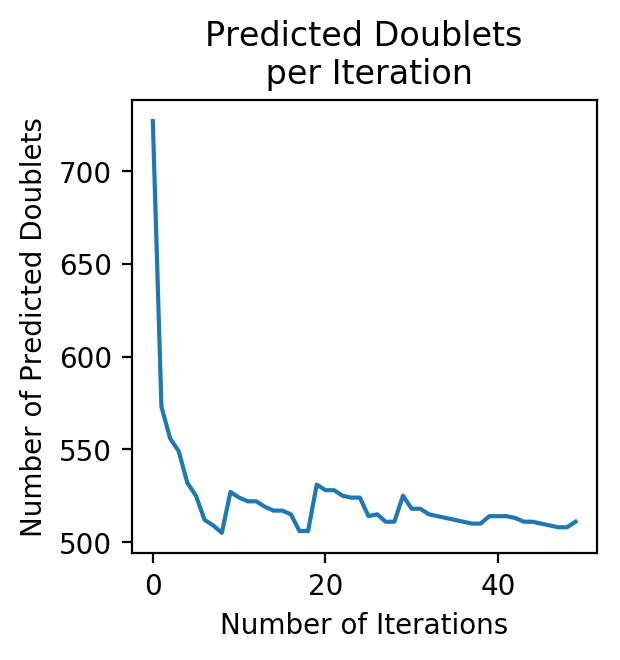

In [6]:
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True)

### Doublets on tSNE map

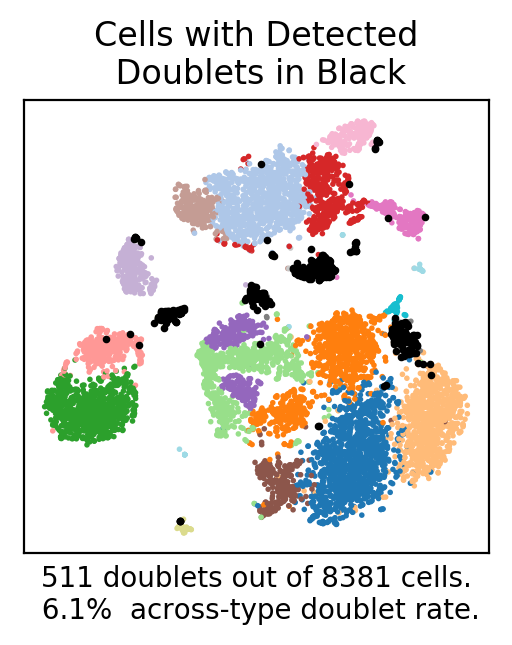

In [7]:
f2, tsne_coords = doubletdetection.plot.tsne(raw_counts, doublets, random_state=1, save='tsne_test.pdf', show=True)

### Number of predicted doublets at different threshold combinations

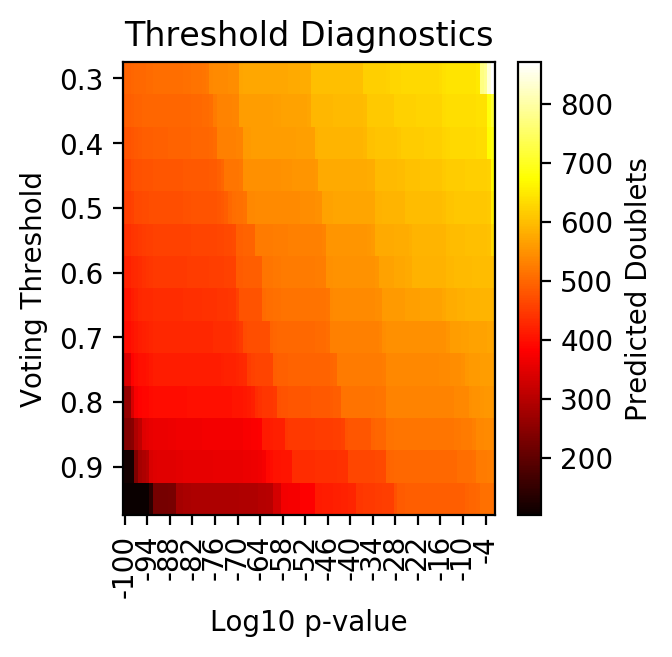

In [ ]:
f3 = doubletdetection.plot.threshold(clf, save='threshold_test.pdf', show=True, p_step=6)

## Measuring PhenoGraph Variability

Even holding the augmented dataset constant (through the `random_state` parameter), PhenoGraph has some variability as shown below. This is part of the motivation for running the classifier many iterations.

In [ ]:
%%capture

cluster_ids = []
parents = []
for i in range(10):
    clf_temp = doubletdetection.BoostClassifier(n_iters=1, random_state=1)
    clf_temp.fit(raw_counts)
    cluster_ids.append(clf_temp.communities_)
    parents.append(clf.parents_)

In [ ]:
# Ensure same exact synthetic doublets are made
parents_np = np.array(parents)
np.sum(parents_np[0] == parents_np[1]) / len(parents_np[0].flatten())

In [ ]:
length = len(cluster_ids)
rands = np.zeros((length, length))
for i in range(length):
    for j in range(length):
        rands[i, j] = adjusted_rand_score(cluster_ids[i].flatten(), cluster_ids[j].flatten())
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.boxplot(rands[np.tril(rands, k=-1) != 0])
ax.set_title('Pairwise Adjusted Rand Score\n from {} Clusterings'.format(length))
ax.set_ylabel('Adjusted Rand Score')
ax.set_xticklabels('')
ax.set_ylim([0.75, 1])
plt.show()